#  **Nettoyage des données V2** 

In [1]:
import s3fs
import pandas as pd

In [2]:
pd.set_option("display.max_columns", None)

## 1) Récupération des données

In [3]:
from scripts.importation import process_all_years_s3

In [4]:
# Connexion au bucket S3
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

ROOT_S3_PATH = "mvallat/diffusion/projet"

In [5]:
# Importation bucket S3
MY_BUCKET = "mvallat/diffusion"
FILE_PATH_S3 = f"{MY_BUCKET}/projet/data_brevets.parquet"

with fs.open(FILE_PATH_S3, 'rb') as file_in:
    data_brevets = pd.read_parquet(file_in)

data_brevets.head(10)

,doc-number,kind,country,status,publication_country,publication_doc-number,publication_date,publication_bopinum,publication_nature,invention-title,applicant_1_orgname,applicant_1_address-1,applicant_1_city,applicant_1_postcode,applicant_1_country,applicant_2_orgname,applicant_2_address-1,applicant_2_city,applicant_2_postcode,applicant_2_country,applicant_3_orgname,applicant_3_address-1,applicant_3_city,applicant_3_postcode,applicant_3_country,inventor_1_last-name,inventor_1_first-name,inventor_1_address-1,inventor_1_city,inventor_1_postcode,inventor_1_country,inventor_2_last-name,inventor_2_first-name,inventor_2_address-1,inventor_2_city,inventor_2_postcode,inventor_2_country,inventor_3_last-name,inventor_3_first-name,inventor_3_address-1,inventor_3_city,inventor_3_postcode,inventor_3_country,agent_1_orgname,agent_1_address-1,agent_1_city,agent_1_postcode,agent_1_country,agent_2_orgname,agent_2_address-1,agent_2_city,agent_2_postcode,agent_2_country,agent_3_orgname,agent_3_address-1,agent_3_city,agent_3_postcode,agent_3_country,owner_1_last-name,owner_1_first-name,owner_1_address-1,owner_1_city,owner_1_postcode,owner_1_country,owner_2_last-name,owner_2_first-name,owner_2_address-1,owner_2_city,owner_2_postcode,owner_2_country,owner_3_last-name,owner_3_first-name,owner_3_address-1,owner_3_city,owner_3_postcode,owner_3_country,classification_1_text,classification_2_text,classification_3_text,abstract,citation_1_type,citation_1_text,citation_1_country,citation_1_doc-number,citation_1_date,citation_2_type,citation_2_text,citation_2_country,citation_2_doc-number,citation_2_date,citation_3_type,citation_3_text,citation_3_country,citation_3_doc-number,citation_3_date,year,application_country,application_doc-number,application_date,last-fee-payement,next-fee-payement,date-search-completed
0,3038352,A1,FR,PUBDEM,FR,3038352,20170106,2017-01,Brevet,ENSEMBLE POUR PANNEAU DE PORTE ET PANNEAU ASSOCIE,FAURECIA INTERIEUR INDUSTRIE None,"2, RUE HENNAPE",NANTERRE,92000,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,BERTINELLI,RAPHAEL,20 RUE D'ECHAVANNE,CHENEBIER,70400,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,"2, PLACE D'ESTIENNE D'ORVES ,",PARIS,75009,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,F16B 5/07 20060101AFI20150702BHFR ...,F16B 5/08 20060101ALI20150702BHFR ...,B60J 5/00 20060101ALI20150702BHFR ...,La présente invention concerne un ensemble (10...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017,None,None,None,None,None,None
1,3038278,A1,FR,PUBDEM,FR,3038278,20170106,2017-01,Brevet,VEHICULE HYBRIDE COMPRENANT UNE SUPPRESSION DE...,IFP ENERGIES NOUVELLES None,1 ET 4 AVENUE DE BOIS-PREAU,RUEIL MALMAISON CEDEX,92852,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,MILOSAVLJEVIC,MISA,17 RUE CLAUDE BENARD,ERAGNY SUR OISE,95610,FR,ZITO,GIANLUCA,12 RUE DE PONTOISE,PARIS,75005,FR,NA,NA,NA,NA,NA,NA,NA,95 RUE D'AMSTERDAM,PARIS CEDEX 8,75378,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,B60W 20/00 20060101AFI20150630BHFR ...,B60W 10/08 20060101ALI20150630BHFR ...,B60W 10/115 20120101ALI20150630BHFR ...,Dans un véhicule hybride comprenant un moteur ...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017,None,None,None,None,None,None
2,3038409,A1,FR,PUBDEM,FR,3038409,20170106,2017-01,Brevet,PROCEDE DE CONCEPTION ASSISTEE PAR ORDINATEUR ...,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE None,3 RUE MICHEL ANGE,PARIS,75016,FR,UNIVERSITE D'AIX-MARSEILLE None,58 BOULEVARD CHARLES LIVON,MARSEILLE CEDEX 7,13284,FR,ECOLE CENTRALE DE MARSEILLE None,TECHNOPOLE DE CHATEAU GOMBERT\n38 RUE FREDERIC...,MARSEILLE,13013,FR,DUPONT,GUILLAUME,28 RUE DE VERDUN,MARSEILLE,13005,FR,ENOCH,STEFAN,15 RUE DE L'ESCALET\nLA COLLINE N°17,MARSEILLE,13013,FR,MOLIN,BERNARD,20 CHEMIN DE LA RESQUILLETTE,VENELLES,13770,FR,NA,310 AVENUE BERTHELOT,LYON,69008,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,G06F 17/50 20060101AFI20150701BHFR ...,G06F 17/11 20060101ALI20150701BHFR ...,E02B 3/06 20060

## 2) Premier tri des demandes de brevet pertinentes

On commence par ...

#### **Suppression de "status" et de "publication_nature"**
Pour notre étude, nous avons choisi de ne pas exploiter les variables "status" et "publication_nature", qui renseignent l’issue de la demande de brevet (délivrance ou non). Leur prise en compte poserait en effet un biais important pour les demandes les plus récentes, qui sont encore en cours d’examen et pourraient être délivrées ultérieurement.

Nous considérons donc les brevets exclusivement comme des demandes de brevet, indépendamment de leur statut final. Ce choix méthodologique nous paraît pertinent dans la mesure où le dépôt d’une demande constitue déjà un indicateur significatif de l’activité inventive et du niveau d’innovation par secteur, qu’elle aboutisse ou non à une délivrance.

In [6]:
data_brevets_clean = data_brevets.drop(columns = ["status", "publication_nature"])

#### **Suppression de "country" et de "publication_country"**

In [7]:
data_brevets_clean["country"].value_counts()

country
FR    112194
NA       101
Name: count, dtype: int64

In [8]:
data_brevets_clean["publication_country"].value_counts()

publication_country
FR    112194
Name: count, dtype: int64

Comme attendu, cette base de données ne contient que des demandes de brevet déposées en France. Nous pouvons donc supprimer ces deux variables.

In [9]:
data_brevets_clean = data_brevets_clean.drop(columns = ["country", "publication_country"])

#### **Sélection en fonction du type de brevet**

Il s'agit d'abord de choisir quel type de brevet nous intéresse, car nos données en contiennent plusieurs types (cf catégorie "kind").

In [10]:
# Colonne "kind"
data_brevets_clean["kind"].value_counts()

kind
A1    107749
A3      4441
NA       102
B1         3
Name: count, dtype: int64

Le document contient trois types de brevets :

- `A1` : demande de brevet  
- `A3` : demande de certificat d'utilité  
- `B1` : brevet délivré  


**Concernant les types B1 (n = 3)** : cette base recensant les demandes de brevet, elle n'est pas censée contenir un brevet B1.  
Probablement dû à une erreur de classification, nous décidons de retirer ces observations.

In [11]:
# Suppression des B1
data_brevets_clean = data_brevets_clean[data_brevets["kind"] != "B1"]

# Vérification qu'on a supprimé 3 observations
data_brevets_clean.shape[0]


112292

Concernant les types A3 (n = 4 441) : les certificats d'utilité sont des certificats délivrés par l'INPI qui protègent l'innovation, tout comme les brevets. En revanche la durée de protection est raccourcie (10 ans contre 20 ans) et la procédure d'examen de la demande est allégée. Pour simplifier l'analyse en la rendant plus homogène, nous ne gardons pas ces demandes A3 dans notre base.

In [12]:
# Suppression des A3
data_brevets_clean = data_brevets_clean[data_brevets_clean["kind"] != "A3"]

# Vérification : suppression de 4 441 observations (112,292 - 4,441 = 107,851)
data_brevets_clean.shape[0]

107851

**Concernant les NA (n = 102)** : plus d'observations sont nécessaires pour décider de la manière de gérer ces NA.


In [13]:
# Observation des NA
brevets_na = data_brevets_clean[data_brevets_clean["kind"] == "NA"]
brevets_na


,doc-number,kind,publication_doc-number,publication_date,publication_bopinum,invention-title,applicant_1_orgname,applicant_1_address-1,applicant_1_city,applicant_1_postcode,applicant_1_country,applicant_2_orgname,applicant_2_address-1,applicant_2_city,applicant_2_postcode,applicant_2_country,applicant_3_orgname,applicant_3_address-1,applicant_3_city,applicant_3_postcode,applicant_3_country,inventor_1_last-name,inventor_1_first-name,inventor_1_address-1,inventor_1_city,inventor_1_postcode,inventor_1_country,inventor_2_last-name,inventor_2_first-name,inventor_2_address-1,inventor_2_city,inventor_2_postcode,inventor_2_country,inventor_3_last-name,inventor_3_first-name,inventor_3_address-1,inventor_3_city,inventor_3_postcode,inventor_3_country,agent_1_orgname,agent_1_address-1,agent_1_city,agent_1_postcode,agent_1_country,agent_2_orgname,agent_2_address-1,agent_2_city,agent_2_postcode,agent_2_country,agent_3_orgname,agent_3_address-1,agent_3_city,agent_3_postcode,agent_3_country,owner_1_last-name,owner_1_first-name,owner_1_address-1,owner_1_city,owner_1_postcode,owner_1_country,owner_2_last-name,owner_2_first-name,owner_2_address-1,owner_2_city,owner_2_postcode,owner_2_country,owner_3_last-name,owner_3_first-name,owner_3_address-1,owner_3_city,owner_3_postcode,owner_3_country,classification_1_text,classification_2_text,classification_3_text,abstract,citation_1_type,citation_1_text,citation_1_country,citation_1_doc-number,citation_1_date,citation_2_type,citation_2_text,citation_2_country,citation_2_doc-number,citation_2_date,citation_3_type,citation_3_text,citation_3_country,citation_3_doc-number,citation_3_date,year,application_country,application_doc-number,application_date,last-fee-payement,next-fee-payement,date-search-completed
285,NA,NA,None,None,None,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017,None,None,None,None,None,None
606,NA,NA,None,None,None,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017,None,None,None,None,None,None
831,NA,NA,None,None,None,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017,None,None,None,None,None,None
1153,NA,NA,None,None,None,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017,None,None,None,None,None,None
1543,NA,NA,None,None,None,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28236,NA,NA,None,None,None,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA

In [14]:
# Vérification du nombre d'informations réellement présentes
brevets_na["doc-number"].nunique()
brevets_na["invention-title"].nunique()

2

On peut constater que seules deux observations contiennent des informations. Nous pouvons donc supprimer toutes les observations qui ne contiennent que des NA.

In [15]:
# Suppression des observations 100% NA
data_brevets_clean = data_brevets_clean[data_brevets_clean["kind"] != "NA"]

## 3) Vérification que les observations sont uniques et gestion des observations vides

On commence par vérifier que la base contient bien une observation pour une demande de brevet et qu'il n'y a pas de doublons. 

#### **Unicité du numéro du document**

In [16]:
# Vérification que doc_number est unique

nb_number = data_brevets_clean["doc-number"].nunique()
print("Nombre de doc-number uniques :", nb_number)

nb_number2 = data_brevets_clean["publication_doc-number"].nunique()
print("Nombre de publication_doc-number uniques :", nb_number2)

nb_observations = data_brevets_clean.shape[0]
print("Nombre total d'observations :", nb_observations)


Nombre de doc-number uniques : 107748
Nombre de publication_doc-number uniques : 107748
Nombre total d'observations : 107749


Nous pouvons constater qu'il y a un seul cas de brevets ayant le même numéro. Nous décidons de garder la demande la plus récente en retenant la demande avec le numéro de dossier le plus récent.

In [17]:
# Repérage des doublons
doublons = data_brevets_clean[data_brevets_clean.duplicated(subset=["doc-number"], keep=False)]
print(doublons)

      doc-number kind publication_doc-number publication_date  \
12476    3050837   A1                3050837         20171103   
58919    3050837   A1                3050837         20171103   

      publication_bopinum                                    invention-title  \
12476             2017-44  DISPOSITIF D'INFORMATION INERTIELLE, SAGITTALE...   
58919             2017-44  DISPOSITIF D'INFORMATION INERTIELLE, SAGITTALE...   

                  applicant_1_orgname      applicant_1_address-1  \
12476  BOARDING RING READING SAS None  661 CHE DU CHATEAU VALLON   
58919       BOARDING RING READING SAS  661 CHE DU CHATEAU VALLON   

      applicant_1_city applicant_1_postcode applicant_1_country  \
12476        OLLIOULES                83190                  FR   
58919        OLLIOULES                83190                  FR   

      applicant_2_orgname applicant_2_address-1 applicant_2_city  \
12476                  NA                    NA               NA   
58919               

In [18]:
# Drop de la demande indexée 12476 (on conserve le numéro 58919)
data_brevets_clean = data_brevets_clean.drop(12476)


Enfin, on peut conserver uniquement une des deux variables qui indique le numéro de demande, par exemple "doc-number" et ne pas garder "publication-doc-number".

In [19]:
data_brevets_clean = data_brevets_clean.drop(columns = ["publication_doc-number"])

#### **Absence d'abstract en double**
Les abstracts sont les résumés des brevets déposés. Il s'agit pour nous de vérifier qu'ils contiennent bien du texte d'une part, et qu'il n'y a pas de doublons d'autre part, afin de s'assurer que chaque numéro de demande correspond bien à une demande effective différente.

In [20]:
counts = data_brevets_clean["abstract"].value_counts()
print("Nombre d'abstracts en double :", len(counts[counts > 1]))

Nombre d'abstracts en double : 1166


In [21]:
data_brevets_NA = data_brevets_clean[
    data_brevets_clean["abstract"] == "NA"
]
data_brevets_NA

,doc-number,kind,publication_date,publication_bopinum,invention-title,applicant_1_orgname,applicant_1_address-1,applicant_1_city,applicant_1_postcode,applicant_1_country,applicant_2_orgname,applicant_2_address-1,applicant_2_city,applicant_2_postcode,applicant_2_country,applicant_3_orgname,applicant_3_address-1,applicant_3_city,applicant_3_postcode,applicant_3_country,inventor_1_last-name,inventor_1_first-name,inventor_1_address-1,inventor_1_city,inventor_1_postcode,inventor_1_country,inventor_2_last-name,inventor_2_first-name,inventor_2_address-1,inventor_2_city,inventor_2_postcode,inventor_2_country,inventor_3_last-name,inventor_3_first-name,inventor_3_address-1,inventor_3_city,inventor_3_postcode,inventor_3_country,agent_1_orgname,agent_1_address-1,agent_1_city,agent_1_postcode,agent_1_country,agent_2_orgname,agent_2_address-1,agent_2_city,agent_2_postcode,agent_2_country,agent_3_orgname,agent_3_address-1,agent_3_city,agent_3_postcode,agent_3_country,owner_1_last-name,owner_1_first-name,owner_1_address-1,owner_1_city,owner_1_postcode,owner_1_country,owner_2_last-name,owner_2_first-name,owner_2_address-1,owner_2_city,owner_2_postcode,owner_2_country,owner_3_last-name,owner_3_first-name,owner_3_address-1,owner_3_city,owner_3_postcode,owner_3_country,classification_1_text,classification_2_text,classification_3_text,abstract,citation_1_type,citation_1_text,citation_1_country,citation_1_doc-number,citation_1_date,citation_2_type,citation_2_text,citation_2_country,citation_2_doc-number,citation_2_date,citation_3_type,citation_3_text,citation_3_country,citation_3_doc-number,citation_3_date,year,application_country,application_doc-number,application_date,last-fee-payement,next-fee-payement,date-search-completed
26036,3064421,A1,20180928,2018-39,ROTOR POUR MOTEUR OU GENERATEUR ELECTROMAGNETI...,WHYLOT SAS None,PARC D'ACTIVITES QUERCYPOLE 2,CAMBES,46100,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,RAVAUD,ROMAIN,8 LES CANAVALS HAUTS,LABASTIDE MURAT,46240,FR,MAYEUR,LOIC,LA CROIX DU FABRE,SAINT SENTIN,12700,FR,NA,NA,NA,NA,NA,NA,NA,PARC D'ACTIVITES QUERCYPOLE 2,CAMBES,46100,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,H02K 1/27 20060101AFI20170918BHFR ...,H02K 1/06 20060101ALI20170918BHFR ...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2018,None,None,None,None,None,None
26188,3064439,A1,20180928,2018-39,DISPOSITIF DE RETROVISION VIDEO POUR VEHICULE ...,DAV None,76 RUE AUGUSTE PERRET - ZI EUROPARC,CRETEIL CEDEX,94046,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,DABIC,STEPHANIE,C/O DAV\n76 RUE AUGUSTE PERRET - ZI EUROPARC,CRETEIL CEDEX,94046,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,SERVICE PROPRIETE INTELLECTUELLE\n76 RUE AUGUS...,CRETEIL CEDEX,94046,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,H04N 5/232 20060101AFI20170322BHFR ...,B60R 1/062 20060101ALI20170322BHFR ...,G06T 7/00 20170101ALI20170322BHFR ...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2018,None,None,None,None,None,None
30080,3068197,A1,20181228,2018-52,CARTOUCHE DE CARACTERISATION ELECTRONIQUE DES ...,SWISSLOG FRANCE,28 QUAI GALLIENI,SURESNES CEDEX,92156,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NDUHURA MUNGA,JUSTIN,28 QUAI GALLIENI,SURESNES,92156,FR,COCHINI,BASTIEN,28 QUAI GALLIENI,SURESNES,92156,FR,BENAMARA,MOHAMED,28 QUAI GALLIENI,SURESNES,92156,FR,NA,24 RUE DE PARIS,HERBLAY,95220,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,28 QUAI GALLIENI,SURESNES CEDEX,92156,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,H05K 1/02 20060101AFI20180313BH ...,F25D 3/08 20060101ALI20180313BH ...,G06Q 50/30 20120101ALI20180313BH ...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2018,FR,1770683,20170627,None,None,None
30673,3068791,A1,20190111,2019-02,ANALYSE APPROFONDIE DE L'ORTEQUE DE VERRE OPHT...,GIROD DENIS PAUL,71 BOULEVARD DE STRASBOURG,LE HAVRE,76600,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,GIROD,DENIS PAUL,71 BOULEVARD DE STRASBOURG,LE HAVRE,76600,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,IC COM SARL (GIROD DENIS),182 QUAI GEORGE V,LE HAVRE,

- **Gestion des NA** : En observant la base de données, on constate que ces abstract vides sont parfois associés à des demandes incomplètes, et parfois le reste de la demande semble complète. Après quelques recherches sur internet, il nous semble que l'explication la plus probable est que ces demandes soient déposées sans leur abstract, qui est fourni plus tard à l'INPI (l'abstract étant obligatoire pour la demande). Pour se concentrer sur les demandes complètes uniquement, nous décidons donc de supprimer ces observations, qui restent en faible nombre par rapport à nos plus de 100,000 observations.

In [22]:
# Drop des NA
data_brevets_clean = data_brevets_clean[
    data_brevets_clean["abstract"] != "NA"
]

# Vérification 
nb_na = (data_brevets_clean["abstract"] == "NA").sum()
print("Nombre de NA après le drop :", nb_na)

Nombre de NA après le drop : 0


- **Gestion des abstracts en double** : 

In [23]:
# compte des abstracts strictement identiques
duplicates = data_brevets_clean[data_brevets_clean.duplicated(subset="abstract", keep=False)]
print("Nombre d'observations avec des doublons :", len(duplicates))

Nombre d'observations avec des doublons : 2691


On commence par parcourir les observations avec des doublons pour se donner une idée de la raison de l'existence de ces doublons.

In [24]:
duplicates.sort_values("abstract")

,doc-number,kind,publication_date,publication_bopinum,invention-title,applicant_1_orgname,applicant_1_address-1,applicant_1_city,applicant_1_postcode,applicant_1_country,applicant_2_orgname,applicant_2_address-1,applicant_2_city,applicant_2_postcode,applicant_2_country,applicant_3_orgname,applicant_3_address-1,applicant_3_city,applicant_3_postcode,applicant_3_country,inventor_1_last-name,inventor_1_first-name,inventor_1_address-1,inventor_1_city,inventor_1_postcode,inventor_1_country,inventor_2_last-name,inventor_2_first-name,inventor_2_address-1,inventor_2_city,inventor_2_postcode,inventor_2_country,inventor_3_last-name,inventor_3_first-name,inventor_3_address-1,inventor_3_city,inventor_3_postcode,inventor_3_country,agent_1_orgname,agent_1_address-1,agent_1_city,agent_1_postcode,agent_1_country,agent_2_orgname,agent_2_address-1,agent_2_city,agent_2_postcode,agent_2_country,agent_3_orgname,agent_3_address-1,agent_3_city,agent_3_postcode,agent_3_country,owner_1_last-name,owner_1_first-name,owner_1_address-1,owner_1_city,owner_1_postcode,owner_1_country,owner_2_last-name,owner_2_first-name,owner_2_address-1,owner_2_city,owner_2_postcode,owner_2_country,owner_3_last-name,owner_3_first-name,owner_3_address-1,owner_3_city,owner_3_postcode,owner_3_country,classification_1_text,classification_2_text,classification_3_text,abstract,citation_1_type,citation_1_text,citation_1_country,citation_1_doc-number,citation_1_date,citation_2_type,citation_2_text,citation_2_country,citation_2_doc-number,citation_2_date,citation_3_type,citation_3_text,citation_3_country,citation_3_doc-number,citation_3_date,year,application_country,application_doc-number,application_date,last-fee-payement,next-fee-payement,date-search-completed
14977,3053138,A1,20171229,2017-52,PROCEDE D'EDITION AUTOMATISEE D'UN BLOC D'UN T...,LUCKY CART None,159 RUE MONTMARTRE,PARIS,75002,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,CHAPPE,OLIVIER,31 Chemin des Grandes Combes 69360 TERNAY,TERNAY,69360,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,"29, RUE DE LISBONNE",PARIS,75008,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,G06F 3/0484 20130101AFI20160622BHFR ...,G06F 3/0482 20130101ALI20160622BHFR ...,NA,\n,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017,None,None,None,None,None,None
14692,3052641,A1,20171222,2017-51,UTILISATION DE XYLITOL POUR AMELIORER LA DISSO...,EUROTAB None,ZAC DES PEYRARDES,ST JUST ST RAMBERT,42170,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,KIRCHHOFF,LAURENT,9 ROUTE DE CHAMBLES,ST JUST ST RAMBERT,42170,FR,GERMAIN,VALERIE,44 RUE ANTONIN PERRIN,VILLEURBANNE,69100,FR,COENRAETS,CHRISTIAN,30 ALLEE DE LA MEUTE,LE VESINET,78110,FR,NA,87 RUE DE SEZE,69477 LYON CEDEX 06,None,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,A23L 2/395 20060101AFI20160620BHFR ...,A23P 10/28 20160101ALI20160620BHFR ...,A23F 3/32 20060101ALI20160620BHFR ...,\n,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017,None,None,None,None,None,None
74543,3112481,A1,20220121,2022-03,COMPOSITION POUR TEINDRE DES FIBRES DE KÉRATIN...,L'OREAL,"14, rue Royale",PARIS,75008,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,MA,Jingmiao,L'OREAL R & D JAPAN KSP R&D B1213 / 3-2-1 SAK...,KAWASAKI,NA,JP,JIANG,YUEHUANG,L'OREAL R&I JAPAN KSP R&D B1213 / 3-2-1 SAKAD...,KAWASAKI,NA,JP,LIU,ZHIBING,L'OREAL R&I JAPAN KSP R&D B1213 / 3-2-1 SAKAD...,KAWASAKI,NA,JP,Lavoix,"62, rue de Bonnel",LYON CEDEX 03,69448,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,"14, rue Royale",PARIS,75008,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,A61K 8/49 20191216AFI20201021BHFR ...,A61K 8/34 20191216ALI20201021BHFR ...,A61Q 5/10 20191216ALI20201021BHFR ...,\n \n \n Composit...,patcit,CN 101 961 302 B (GUANGZHOU YOUNGRACE\nDAILY C...,CN,CN-101961302-B,20130529,patcit,CN 107 349 131 A (ZHONGSHAN JIALI FINE\nCHEMIC...,CN,CN-107349131-A,20171117,patcit,GB 1 065 223 A (OREAL)\n12 avril 1967 (1967-04...,GB,GB-1065223-A,19670412,2022,FR,2007612,20200720,20210611,20220801,20220121
72807,3110847,A1,20211203,2021-48,COM

**Cas des doublons parfaits :**

On veut d'abord vérifier si il existe des observations qui ont exactement les mêmes valeurs pour toutes les variables sauf pour le numéro de dossier.

In [25]:
# Vérification existance doublon parfait
cols_comparaison = [
    c for c in data_brevets_clean.columns
    if c not in ["doc_number", "publication_doc_number"]
]


n_duplicates = data_brevets_clean.duplicated(
    subset=cols_comparaison
).sum()
print(n_duplicates)

0


Il n'y a donc aucun doublon parfait ! Toutes les demandes avec le même abstract ne sont pas identiques pour toutes les variables (au-delà du fait que les demandes n'ont évidemment pas le même numéro).

**Gestion des doublons :**

Nous émettons l'hypothèse que les observations avec des NA en double correspondent à la même demande de brevet déposée plusieurs fois afin d'ajouter une correction d'une version à une autre. Ainsi, nous choisissons de considérer que la demande la plus récente entre les doublons est la demande la plus aboutie, et donc la seule que nous garderons. Pour garder la demande la plus récente, on peut utiliser la date de la demande. Dans le cas où la date est la même, il suffit de garder la demande avec le numéro de dossier le plus élevé car ce numéro augmente d'une unité pour chaque nouvelle demande.

In [26]:
# Garder la demande la plus ancienne parmi les doublons

## Passer publication_date au format date
data_brevets_clean["publication_date"] = pd.to_datetime(
    data_brevets_clean["publication_date"],
    format="%Y%m%d",
    errors="coerce"
)
## Trouver la date la plus ancienne par abstract
max_date_per_abstract = (
    duplicates
    .groupby("abstract")["publication_date"]
    .transform("max")
)

## Garder les doublons les plus récents
duplicates_keep = duplicates[
    duplicates["publication_date"] == max_date_per_abstract
]

## Reconstruire la base
data_brevets_clean2 = pd.concat(
    [
        data_brevets_clean[~data_brevets_clean.index.isin(duplicates.index)],
        duplicates_keep
    ],
    axis=0
).sort_index()

## Compter le nouveau nombre de brevets
duplicates2 = data_brevets_clean2[data_brevets_clean2.duplicated(subset="abstract", keep=False)]
print("Nouveau nombre d'observations avec des doublons (drop quand différence de date):", len(duplicates2))


Nouveau nombre d'observations avec des doublons (drop quand différence de date): 1872


In [27]:
# Garder la demande avec le numéro de demande le plus élevée.

## Passer doc-number au format numérique
data_brevets_clean2["doc-number"] = pd.to_numeric(
    data_brevets_clean2["doc-number"],
    errors="coerce"
)

## Trouver le numéro maximal par doublon
max_doc_number = (
    duplicates2
    .groupby("abstract")["doc-number"]
    .transform("max")
)

## Drop les doublons avec le plus petit numéro
duplicates_keep = duplicates2[
    duplicates2["doc-number"] == max_doc_number
]

## Base finale
data_brevets_clean3 = pd.concat(
    [
        data_brevets_clean2[~data_brevets_clean2.index.isin(duplicates2.index)],
        duplicates_keep
    ],
    axis=0
).sort_index()


## Compter le nouveau nombre de brevets
duplicates3 = data_brevets_clean3[data_brevets_clean3.duplicated(subset="abstract", keep=False)]
print("Nouveau nombre d'observations avec des doublons (drop par numéro):", len(duplicates3))


Nouveau nombre d'observations avec des doublons (drop par numéro): 0


In [28]:
print("Nombre d'observations dans la base:", len(data_brevets_clean3))
print("Nombre d'observations avec des abstracts uniques:", data_brevets_clean3["abstract"].nunique())

Nombre d'observations dans la base: 105883
Nombre d'observations avec des abstracts uniques: 105883


## 4) Sélection des variables pertinentes

In [29]:
data_brevets_clean3.head(5)


,doc-number,kind,publication_date,publication_bopinum,invention-title,applicant_1_orgname,applicant_1_address-1,applicant_1_city,applicant_1_postcode,applicant_1_country,applicant_2_orgname,applicant_2_address-1,applicant_2_city,applicant_2_postcode,applicant_2_country,applicant_3_orgname,applicant_3_address-1,applicant_3_city,applicant_3_postcode,applicant_3_country,inventor_1_last-name,inventor_1_first-name,inventor_1_address-1,inventor_1_city,inventor_1_postcode,inventor_1_country,inventor_2_last-name,inventor_2_first-name,inventor_2_address-1,inventor_2_city,inventor_2_postcode,inventor_2_country,inventor_3_last-name,inventor_3_first-name,inventor_3_address-1,inventor_3_city,inventor_3_postcode,inventor_3_country,agent_1_orgname,agent_1_address-1,agent_1_city,agent_1_postcode,agent_1_country,agent_2_orgname,agent_2_address-1,agent_2_city,agent_2_postcode,agent_2_country,agent_3_orgname,agent_3_address-1,agent_3_city,agent_3_postcode,agent_3_country,owner_1_last-name,owner_1_first-name,owner_1_address-1,owner_1_city,owner_1_postcode,owner_1_country,owner_2_last-name,owner_2_first-name,owner_2_address-1,owner_2_city,owner_2_postcode,owner_2_country,owner_3_last-name,owner_3_first-name,owner_3_address-1,owner_3_city,owner_3_postcode,owner_3_country,classification_1_text,classification_2_text,classification_3_text,abstract,citation_1_type,citation_1_text,citation_1_country,citation_1_doc-number,citation_1_date,citation_2_type,citation_2_text,citation_2_country,citation_2_doc-number,citation_2_date,citation_3_type,citation_3_text,citation_3_country,citation_3_doc-number,citation_3_date,year,application_country,application_doc-number,application_date,last-fee-payement,next-fee-payement,date-search-completed
0,3038352,A1,2017-01-06 00:00:00,2017-01,ENSEMBLE POUR PANNEAU DE PORTE ET PANNEAU ASSOCIE,FAURECIA INTERIEUR INDUSTRIE None,"2, RUE HENNAPE",NANTERRE,92000,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,BERTINELLI,RAPHAEL,20 RUE D'ECHAVANNE,CHENEBIER,70400,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,"2, PLACE D'ESTIENNE D'ORVES ,",PARIS,75009,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,F16B 5/07 20060101AFI20150702BHFR ...,F16B 5/08 20060101ALI20150702BHFR ...,B60J 5/00 20060101ALI20150702BHFR ...,La présente invention concerne un ensemble (10...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017,None,None,None,None,None,None
1,3038278,A1,2017-01-06 00:00:00,2017-01,VEHICULE HYBRIDE COMPRENANT UNE SUPPRESSION DE...,IFP ENERGIES NOUVELLES None,1 ET 4 AVENUE DE BOIS-PREAU,RUEIL MALMAISON CEDEX,92852,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,MILOSAVLJEVIC,MISA,17 RUE CLAUDE BENARD,ERAGNY SUR OISE,95610,FR,ZITO,GIANLUCA,12 RUE DE PONTOISE,PARIS,75005,FR,NA,NA,NA,NA,NA,NA,NA,95 RUE D'AMSTERDAM,PARIS CEDEX 8,75378,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,B60W 20/00 20060101AFI20150630BHFR ...,B60W 10/08 20060101ALI20150630BHFR ...,B60W 10/115 20120101ALI20150630BHFR ...,Dans un véhicule hybride comprenant un moteur ...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017,None,None,None,None,None,None
2,3038409,A1,2017-01-06 00:00:00,2017-01,PROCEDE DE CONCEPTION ASSISTEE PAR ORDINATEUR ...,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE None,3 RUE MICHEL ANGE,PARIS,75016,FR,UNIVERSITE D'AIX-MARSEILLE None,58 BOULEVARD CHARLES LIVON,MARSEILLE CEDEX 7,13284,FR,ECOLE CENTRALE DE MARSEILLE None,TECHNOPOLE DE CHATEAU GOMBERT\n38 RUE FREDERIC...,MARSEILLE,13013,FR,DUPONT,GUILLAUME,28 RUE DE VERDUN,MARSEILLE,13005,FR,ENOCH,STEFAN,15 RUE DE L'ESCALET\nLA COLLINE N°17,MARSEILLE,13013,FR,MOLIN,BERNARD,20 CHEMIN DE LA RESQUILLETTE,VENELLES,13770,FR,NA,310 AVENUE BERTHELOT,LYON,69008,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,G06F 17/50 20060101AFI20150701BHFR ...,G06F 17/11 20060101ALI20150701BHFR ...,E02B 3/06 20060101ALI20150701BHFR ...,Ce procédé de conception assistée par ordinate...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2017,None,

Nous commençons par supprimer quelques variables qui n'apportent aucune nouvelle information, à savoir :
- `kind` car nous n'avons gardé que les brevets de type A1
- `publication_bopinum` qui correspond au numéro de la semaine de la date de publication. Nous conservons uniquement "publication_date" qui donne la même information.
- Les variables au format `application_...` qui contiennent les mêmes informations sur le pays, la date et le numéro de la demande mais cette balise n'était pas présente pour toutes les années, elles contiennent donc beaucoup de valeurs manquantes et n'apportent aucune information nouvelle.
- `date-search-completed`, la date de complétion de la recherche.



Nous supprimons également toutes les variables qui nous semblent peu utiles pour notre sujet et qui ne contiennent pas d'informations intéressantes pour des statistiques descriptives, à savoir :
- Toutes les variables au format `citation_...` qui renseignent sur les "citations" du brevet, c'est-à-dire les références à des documents antérieurs qui sont mentionnés parce qu’ils sont pertinents pour apprécier la nouveauté de l’invention
- `last-fee-payement` et `next-fee-payement` qui donnent les dates de paiement du brevet passées et à venir.


In [30]:
# Drop de ces variables
data_brevets_finale = data_brevets_clean3.drop(columns = ["kind", "publication_bopinum", "date-search-completed", "last-fee-payement", "next-fee-payement",])

data_brevets_finale.drop(columns = data_brevets_finale.filter(regex="^citation").columns, inplace=True)
data_brevets_finale.drop(columns = data_brevets_finale.filter(regex="^application").columns, inplace=True)

data_brevets_finale.head(5)

,doc-number,publication_date,invention-title,applicant_1_orgname,applicant_1_address-1,applicant_1_city,applicant_1_postcode,applicant_1_country,applicant_2_orgname,applicant_2_address-1,applicant_2_city,applicant_2_postcode,applicant_2_country,applicant_3_orgname,applicant_3_address-1,applicant_3_city,applicant_3_postcode,applicant_3_country,inventor_1_last-name,inventor_1_first-name,inventor_1_address-1,inventor_1_city,inventor_1_postcode,inventor_1_country,inventor_2_last-name,inventor_2_first-name,inventor_2_address-1,inventor_2_city,inventor_2_postcode,inventor_2_country,inventor_3_last-name,inventor_3_first-name,inventor_3_address-1,inventor_3_city,inventor_3_postcode,inventor_3_country,agent_1_orgname,agent_1_address-1,agent_1_city,agent_1_postcode,agent_1_country,agent_2_orgname,agent_2_address-1,agent_2_city,agent_2_postcode,agent_2_country,agent_3_orgname,agent_3_address-1,agent_3_city,agent_3_postcode,agent_3_country,owner_1_last-name,owner_1_first-name,owner_1_address-1,owner_1_city,owner_1_postcode,owner_1_country,owner_2_last-name,owner_2_first-name,owner_2_address-1,owner_2_city,owner_2_postcode,owner_2_country,owner_3_last-name,owner_3_first-name,owner_3_address-1,owner_3_city,owner_3_postcode,owner_3_country,classification_1_text,classification_2_text,classification_3_text,abstract,year
0,3038352,2017-01-06 00:00:00,ENSEMBLE POUR PANNEAU DE PORTE ET PANNEAU ASSOCIE,FAURECIA INTERIEUR INDUSTRIE None,"2, RUE HENNAPE",NANTERRE,92000,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,BERTINELLI,RAPHAEL,20 RUE D'ECHAVANNE,CHENEBIER,70400,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,"2, PLACE D'ESTIENNE D'ORVES ,",PARIS,75009,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,F16B 5/07 20060101AFI20150702BHFR ...,F16B 5/08 20060101ALI20150702BHFR ...,B60J 5/00 20060101ALI20150702BHFR ...,La présente invention concerne un ensemble (10...,2017
1,3038278,2017-01-06 00:00:00,VEHICULE HYBRIDE COMPRENANT UNE SUPPRESSION DE...,IFP ENERGIES NOUVELLES None,1 ET 4 AVENUE DE BOIS-PREAU,RUEIL MALMAISON CEDEX,92852,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,MILOSAVLJEVIC,MISA,17 RUE CLAUDE BENARD,ERAGNY SUR OISE,95610,FR,ZITO,GIANLUCA,12 RUE DE PONTOISE,PARIS,75005,FR,NA,NA,NA,NA,NA,NA,NA,95 RUE D'AMSTERDAM,PARIS CEDEX 8,75378,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,B60W 20/00 20060101AFI20150630BHFR ...,B60W 10/08 20060101ALI20150630BHFR ...,B60W 10/115 20120101ALI20150630BHFR ...,Dans un véhicule hybride comprenant un moteur ...,2017
2,3038409,2017-01-06 00:00:00,PROCEDE DE CONCEPTION ASSISTEE PAR ORDINATEUR ...,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE None,3 RUE MICHEL ANGE,PARIS,75016,FR,UNIVERSITE D'AIX-MARSEILLE None,58 BOULEVARD CHARLES LIVON,MARSEILLE CEDEX 7,13284,FR,ECOLE CENTRALE DE MARSEILLE None,TECHNOPOLE DE CHATEAU GOMBERT\n38 RUE FREDERIC...,MARSEILLE,13013,FR,DUPONT,GUILLAUME,28 RUE DE VERDUN,MARSEILLE,13005,FR,ENOCH,STEFAN,15 RUE DE L'ESCALET\nLA COLLINE N°17,MARSEILLE,13013,FR,MOLIN,BERNARD,20 CHEMIN DE LA RESQUILLETTE,VENELLES,13770,FR,NA,310 AVENUE BERTHELOT,LYON,69008,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,G06F 17/50 20060101AFI20150701BHFR ...,G06F 17/11 20060101ALI20150701BHFR ...,E02B 3/06 20060101ALI20150701BHFR ...,Ce procédé de conception assistée par ordinate...,2017
3,3038425,2017-01-06 00:00:00,DOCUMENT ELECTRONIQUE TEL QU'UNE CARTE A PUCE ...,OBERTHUR TECHNOLOGIES None,420 RUE D'ESTIENNE D'ORVES,COLOMBES,92700,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,GRAGNIC,ELODIE,"C/O OBERTHUR TECHNOLOGIES, 420 RUE D'ESTIENNE ...",COLOMBES,92700,FR,BOSQUET,OLIVIER,"C/O OBERTHUR TECHNOLOGIES, 420 RUE D'ESTIENNE ...",COLOMBES,92700,FR,NA,NA,NA,NA,NA,NA,NA,"49,AVENUE DES CHAMPS ELYSEES",PARIS,75008,FR,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,G06K 19/077 20060101AFI20150630BHFR ...,G06K 19/02 20060101ALI20150630BHFR ...,NA,La fabrication d'un document électronique comp...,2017
4,

Pour le moment, nous conservons donc les variables suivantes : 
- `doc-number` : numéro de publication du document de brevet.
- `publication_date` : date de publication officielle de la demande de brevet (la date correspond au lundi de la semaine de dépôt)
- `invention-title` : titre de l’invention tel que publié.
- `year` : année de publication, extraite de la date de publication.


- Variables `applicant_n_...` : nom et adresse du n-ième déposant (nous n'avons téléchargé les informations que pour les trois premiers déposants)
- Variables `inventor_n_...` : nom et adresse du n-ième inventeur (nous n'avons téléchargé les informations que pour les trois premiers inventeurs)
- Variables `agent_n_...` : nom et adresse du n-ième mandataire (nous n'avons téléchargé les informations que pour les trois premiers mandataires)
- Variables `owner_n_...` : nom et adresse du n-ième propriétaire (nous n'avons téléchargé les informations que pour les trois premiers propriétaires)

- `classification_1_text`, `classification_2_text`, `classification_3_text` : trois premiers codes de classification internationale des brevets (CIB / IPC), décrivant le domaine technologique de l’invention. Ces sont les variables que nous utiliseront pour mener une analyse sectorielle.

- `abstract` : résumé de l’invention tel que publié.  

**Ces variables forment la base de donnée finale que nous utiliserons pour les premières statistiques descriptives, que nous nommons "data_brevets_finale"**

**De plus, nous créons une base allégée qui ne contient plus les variables pour les déposants, inventeurs, mandataires et propriétaires. Ces variables seront intéressantes pour faire quelques statistiques descriptives mais elles sont nombreuses, ce qui complique l'exploration des données, et ne nous seront pas utiles pour notre partie analyse.**

In [31]:
data_brevets_light = data_brevets_finale.drop(columns=data_brevets_finale.filter(regex="^(applicant|inventor|agent|owner)").columns)

data_brevets_light.head(5)

,doc-number,publication_date,invention-title,classification_1_text,classification_2_text,classification_3_text,abstract,year
0,3038352,2017-01-06 00:00:00,ENSEMBLE POUR PANNEAU DE PORTE ET PANNEAU ASSOCIE,F16B 5/07 20060101AFI20150702BHFR ...,F16B 5/08 20060101ALI20150702BHFR ...,B60J 5/00 20060101ALI20150702BHFR ...,La présente invention concerne un ensemble (10...,2017
1,3038278,2017-01-06 00:00:00,VEHICULE HYBRIDE COMPRENANT UNE SUPPRESSION DE...,B60W 20/00 20060101AFI20150630BHFR ...,B60W 10/08 20060101ALI20150630BHFR ...,B60W 10/115 20120101ALI20150630BHFR ...,Dans un véhicule hybride comprenant un moteur ...,2017
2,3038409,2017-01-06 00:00:00,PROCEDE DE CONCEPTION ASSISTEE PAR ORDINATEUR ...,G06F 17/50 20060101AFI20150701BHFR ...,G06F 17/11 20060101ALI20150701BHFR ...,E02B 3/06 20060101ALI20150701BHFR ...,Ce procédé de conception assistée par ordinate...,2017
3,3038425,2017-01-06 00:00:00,DOCUMENT ELECTRONIQUE TEL QU'UNE CARTE A PUCE ...,G06K 19/077 20060101AFI20150630BHFR ...,G06K 19/02 20060101ALI20150630BHFR ...,NA,La fabrication d'un document électronique comp...,2017
4,3038316,2017-01-06 00:00:00,PROCEDE DE SYNTHESE EN CONTINU D'UN ELASTOMERE...,C08C 19/44 20060101AFI20150702BHFR ...,C08C 19/25 20060101ALI20150702BHFR ...,C08F 297/04 20060101ALI20150702BHFR ...,L'invention concerne un procédé de synthèse en...,2017


# Statistiques descriptives

In [59]:
# Garder que les quatre premiers termes de la classification
cols_classif = ["classification_1_text", "classification_2_text", "classification_3_text"]

for col in cols_classif:
    data_brevets_light[col] = data_brevets_light[col].str.extract(r"^([A-Z]\d{2})")
data_brevets_light

,doc-number,publication_date,invention-title,classification_1_text,classification_2_text,classification_3_text,abstract,year
0,3038352,2017-01-06 00:00:00,ENSEMBLE POUR PANNEAU DE PORTE ET PANNEAU ASSOCIE,F16,F16,B60,La présente invention concerne un ensemble (10...,2017
1,3038278,2017-01-06 00:00:00,VEHICULE HYBRIDE COMPRENANT UNE SUPPRESSION DE...,B60,B60,B60,Dans un véhicule hybride comprenant un moteur ...,2017
2,3038409,2017-01-06 00:00:00,PROCEDE DE CONCEPTION ASSISTEE PAR ORDINATEUR ...,G06,G06,E02,Ce procédé de conception assistée par ordinate...,2017
3,3038425,2017-01-06 00:00:00,DOCUMENT ELECTRONIQUE TEL QU'UNE CARTE A PUCE ...,G06,G06,NaN,La fabrication d'un document électronique comp...,2017
4,3038316,2017-01-06 00:00:00,PROCEDE DE SYNTHESE EN CONTINU D'UN ELASTOMERE...,C08,C08,C08,L'invention concerne un procédé de synthèse en...,2017
...,...,...,...,...,...,...,...,...
112290,3150391,2024-12-27 00:00:00,Dispositif de refroidissement configuré pour r...,H05,H05,NaN,\n Titre : Dispositif de refroidissement co...,2024
112291,3150392,2024-12-27 00:00:00,Dispositif de refroidissement configuré pour r...,H05,H05,NaN,\n Titre : Dispositif de refroidissement co...,2024
112292,3150393,2024-12-27 00:00:00,Boîtier d’appareil électronique comportant un ...,H05,H05,NaN,\n Un boîtier d’appareil électronique (1) c...,2024
112293,3150394,2024-12-27 00:00:00,Commutateur à base de matériau à changement de...,H10,NaN,NaN,\n Commutateur à base de matériau à changem...,2024


In [60]:
# Créer base compte classification

brevets_long = data_brevets_light.melt(
    id_vars=["doc-number", "year"],
    value_vars=cols_classif,
    value_name="classification"
)
brevets_long

# enlever doublons intra brevets
brevets_long = brevets_long.drop_duplicates(
    subset=["doc-number", "year", "classification"]
)


In [61]:
stats_classification = (
    brevets_long
    .groupby(["classification", "year"])
    .size()
    .reset_index(name="nombre")
)
stats_classification

,classification,year,nombre
0,A01,2017,306
1,A01,2018,269
2,A01,2019,317
3,A01,2020,271
4,A01,2021,266
...,...,...,...
973,H05,2022,169
974,H05,2023,187
975,H05,2024,187
976,H10,2023,25


In [62]:
import matplotlib.pyplot as plt


In [63]:
def plot_evolution_classification(df, classification):
    data = df[df["classification"] == classification].sort_values("year")

    plt.figure()
    plt.plot(data["year"], data["nombre"], marker="o")
    plt.xlabel("Année")
    plt.ylabel("Nombre de brevets")
    plt.title(f"Évolution des brevets – {classification}")
    plt.grid(True)
    plt.show()


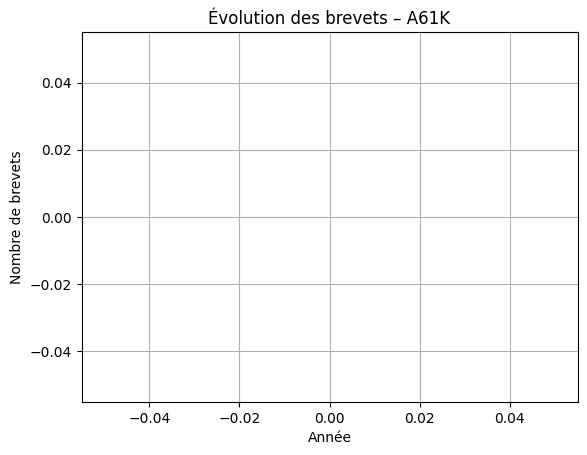

In [64]:
plot_evolution_classification(stats_classification, "A61K")


In [65]:
def plot_top_classifications(df, n=5):
    top_classes = (
        df.groupby("classification")["nombre"]
        .sum()
        .sort_values(ascending=False)
        .head(n)
        .index
    )

    df_top = df[df["classification"].isin(top_classes)]

    plt.figure()
    for c in top_classes:
        data = df_top[df_top["classification"] == c].sort_values("year")
        plt.plot(data["year"], data["nombre"], marker="o", label=c)

    plt.xlabel("Année")
    plt.ylabel("Nombre de brevets")
    plt.title(f"Évolution des {n} principales classifications")
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True)
    plt.show()


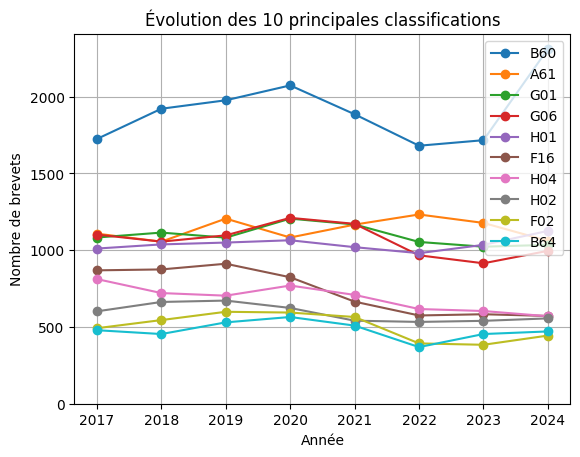

In [66]:
plot_top_classifications(stats_classification, n=10)
